In [1]:
import os,sys, re
from importlib import reload
import numpy as np
import pandas as pd
from Bio.Seq import reverse_complement
#import torch
print(os.getpid())
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares")

from ChromAn.src.library_tools.primers import load_fasta_to_DataFrame
#import MERFISH_probe_design.probe_design.OTTable_dict as ot

2219283


In [2]:
from ChromAn.src.file_io.data_organization import Color_Usage, search_fovs_in_folders, color_usage_kwds

In [3]:
import ChromAn
reload(ChromAn.src.file_io.data_organization)
from ChromAn.src.file_io.data_organization import Data_Organization, search_fovs_in_folders
from ChromAn.src.file_io.dax_process import DaxProcesser
from ChromAn.src.visual_tools.interactive import imshow_mark_3d

In [4]:
# where the original data saves
data_folder =  r"/lab/weissman_imaging/puzheng/msBrain/20240620-EAEPeakCord_MF5"
#data_folder = os.path.join(data_home, '4T1Tumor', '20240504-fullyEdited4T1_MF8')

experiment_date = os.path.basename(data_folder).split('-')[0]
print(experiment_date)
# Color usage file marks the organization of imaging files
color_usage_filename = os.path.join(data_folder, 'Analysis', 'color_usage_MF5_v2.csv')
print(os.path.exists(color_usage_filename))

20240620
True


In [5]:
# visualize some images:
folders, fovs = search_fovs_in_folders(data_folder)
sel_fov = 20

test_ref_filename = os.path.join(folders[0], fovs[sel_fov])
test_filename = os.path.join(folders[1], fovs[sel_fov])
# load ref
daxp_ref = DaxProcesser(test_ref_filename)
daxp_ref._load_image()
#daxp_ref._corr_hot_pixels()
# load
daxp = DaxProcesser(test_filename)
daxp._load_image()
#daxp._corr_hot_pixels()
daxp._calculate_drift(RefImage=daxp_ref.im_477, FiducialChannel='477')

- searching in folder: /lab/weissman_imaging/puzheng/msBrain/20240620-EAEPeakCord_MF5
-- 13 folders, 63 fovs detected.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240620-EAEPeakCord_MF5/H0M1/Conv_zscan_20.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240620-EAEPeakCord_MF5/H0M1/Conv_zscan_20_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['748', '637', '477', '405'] in 2.496s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240620-EAEPeakCord_MF5/H1M2/Conv_zscan_20.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240620-EAEPeakCord_MF5/H1M2/Conv_zscan_20_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['748', '637', '477'] in 1.884s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- 

(array([ 0.        ,  3.27666667, -3.21333333]), 1)

### Quickly visualize bead image to find bead-localizing z-frame

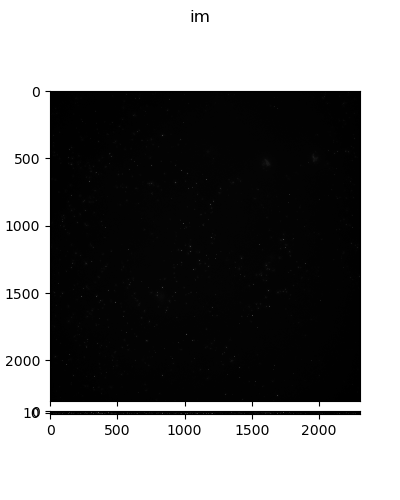

In [ ]:
%matplotlib widget
imshow_mark_3d([daxp.im_477, daxp_ref.im_477], image_names=['im', 'ref'])

In [6]:
# Load readout names:
library_folder = r'/lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF5-EAE_neural_immune'
readout_filename = os.path.join(library_folder, 'readouts.csv')

if os.path.exists(readout_filename):
    readouts = pd.read_csv(readout_filename) 
else:
    # generate readout_file
    import MERFISH_probe_design.IO.file_io as fio
    merfish_bits_file = os.path.join(r'/lab/solexa_weissman/puzheng/References/Readouts', 'MERFISH_readouts.fasta')
    merfish_bits = fio.load_fasta_into_df(merfish_bits_file)
    # first 22 bits are for this library:
    readouts = {'Name':[_id.split('-')[-1] for _id in merfish_bits.loc[:, 'id']], 
                'Sequence':merfish_bits.loc[:, 'sequence']}
    readouts = pd.DataFrame(readouts)
    # save this readout
    readouts.to_csv(readout_filename, index=None)
# select names
readout_names = list(readouts['Name'])
print(len(readout_names), readout_names)

22 ['b1-RS0015', 'b2-RS0083', 'b3-RS0095', 'b4-RS0109', 'b5-RS0175', 'b6-RS0237', 'b7-RS0247', 'b10-RS0332', 'b11-RS0343', 'b12-RS0384', 'b13-RS0406', 'b14-RS0451', 'b15-RS0468', 'b16-RS0548', 'b17-RS0578', 'b18-RS0584', 'b20-RS0707', 'b22-RS0730', 'b23-RS0763', 'b24-RS0793', 'b26-RS0820', 'b27-RS0896']


In [7]:
# Generate data organization
data_organization_folder = r'/lab/weissman_imaging/puzheng/Softwares/Weissman_MERFISH_Scripts/merlin_parameters/dataorganization'

data_organization_filename = os.path.join(data_organization_folder, 
                                          f'{experiment_date}-{os.path.basename(library_folder).split("_")[0]}_{len(readout_names)}bit.csv')

_do = Data_Organization(data_organization_filename,)
if _do.is_empty():
    # create
    _do.create_from_colorUsage(color_usage_filename, data_folder, None, readout_names=readout_names, reorganized=False)
    # save
    _do.save_to_file(overwrite=True)

- load color_usage from file: /lab/weissman_imaging/puzheng/msBrain/20240620-EAEPeakCord_MF5/Analysis/color_usage_MF5_v2.csv
- searching in folder: /lab/weissman_imaging/puzheng/msBrain/20240620-EAEPeakCord_MF5
-- 13 folders, 63 fovs detected.
MERFISHbit 0 bit-1 748 H0M1
MERFISHbit 1 bit-2 637 H0M1
MERFISHbit 2 bit-3 748 H1M2
MERFISHbit 3 bit-4 637 H1M2
MERFISHbit 4 bit-5 748 H2M3
MERFISHbit 5 bit-6 637 H2M3
MERFISHbit 6 bit-7 748 H3M4
MERFISHbit 7 bit-8 637 H3M4
MERFISHbit 8 bit-9 748 H4M5
MERFISHbit 9 bit-10 637 H4M5
MERFISHbit 10 bit-11 748 H5M6
MERFISHbit 11 bit-12 637 H5M6
MERFISHbit 12 bit-13 748 H6M7
MERFISHbit 13 bit-14 637 H6M7
MERFISHbit 14 bit-15 748 H7M8
MERFISHbit 15 bit-16 637 H7M8
MERFISHbit 16 bit-17 748 H8M9
MERFISHbit 17 bit-18 637 H8M9
MERFISHbit 18 bit-19 748 H9M10
MERFISHbit 19 bit-20 637 H9M10
MERFISHbit 20 bit-21 748 H10M11
MERFISHbit 21 bit-22 637 H10M11
- 22 MERFISH rows appended.
Other info: DAPI 405 H0M1
Other info: PolyT 637 H11M12
Saving data_organization i

In [8]:
_do

,channelName,readoutName,imageType,imageRegExp,bitNumber,imagingRound,color,frame,zPos,fiducialImageType,fiducialRegExp,fiducialImagingRound,fiducialFrame,fiducialColor
0,bit1,b1-RS0015,Conv_zscan,H(?P<imagingRound>[0-9]+)M([0-9]+)/(?P<imageTy...,1,0,748,[0 4 8 12 16 20 24 28 32 36 40],[-6.6 -5.4 -4.2 -3.0 -1.8 -0.6 0.6 1.8 3.0 4.2...,Conv_zscan,H(?P<imagingRound>[0-9]+)M([0-9]+)/(?P<imageTy...,0,[2 6 10 14 18 22 26 30 34 38 42],477
1,bit2,b2-RS0083,Conv_zscan,H(?P<imagingRound>[0-9]+)M([0-9]+)/(?P<imageTy...,2,0,637,[1 5 9 13 17 21 25 29 33 37 41],[-6.6 -5.4 -4.2 -3.0 -1.8 -0.6 0.6 1.8 3.0 4.2...,Conv_zscan,H(?P<imagingRound>[0-9]+)M([0-9]+)/(?P<imageTy...,0,[2 6 10 14 18 22 26 30 34 38 42],477
2,bit3,b3-RS0095,Conv_zscan,H(?P<imagingRound>[0-9]+)M([0-9]+)/(?P<imageTy...,3,1,748,[0 3 6 9 12 15 18 21 24 27 30],[-6.6 -5.4 -4.2 -3.0 -1.8 -0.6 0.6 1.8 3.0 4.2...,Conv_zscan,H(?P<imagingRound>[0-9]+)M([0-9]+)/(?P<imageTy...,1,[2 5 8 11 14 17 20 23 26 29 32],477
3,bit4,b4-RS0109,Conv_zscan,H(?P<imagingRound>[0-9]+)M([0-9]+)/(?P<imageTy...,4,1,637,[1 4 7 10 13 16 19 22 25 28 31],[-6.6 -5.4 -4.2 -3.0 -1.8 -0.6 0.6 1.8 3.0 4.2...,Conv_zscan,H(?P<imagingRound>[0-9]+)M([0-9]+)/(?P<imageTy...,1,[2 5 8 11 14 17 20 23 26 29 32],477
4,bit5,b5-RS0175,Conv_zscan,H(?P<imagingRound>[0-9]+)M([0-9]+)/(?P<imageTy...,5,2,748,[0 3 6 9 12 15 18 21 24 27 30],[-6.6 -5.4 -4.2 -3.0 -1.8 -0.6 0.6 1.8 3.0 4.2...,Conv_zscan,H(?P<imagingRound>[0-9]+)M([0-9]+)/(?P<imageTy...,2,[2 5 8 11 14 17 20 23 26 29 32],477
5,bit6,b6-RS0237,Conv_zscan,H(?P<imagingRound>[0-9]+)M([0-9]+)/(?P<imageTy...,6,2,637,[1 4 7 10 13 16 19 22 25 28 31],[-6.6 -5.4 -4.2 -3.0 -1.8 -0.6 0.6 1.8 3.0 4.2...,Conv_zscan,H(?P<imagingRound>[0-9]+)M([0-9]+)/(?P<imageTy...,2,[2 5 8 11 14 17 20 23 26 29 32],477
6,bit7,b7-RS0247,Conv_zscan,H(?P<imagingRound>[0-9]+)M([0-9]+)/(?P<imageTy...,7,3,748,[0 3 6 9 12 15 18 21 24 27 30],[-6.6 -5.4 -4.2 -3.0 -1.8 -0.6 0.6 1.8 3.0 4.2...,Conv_zscan,H(?P<imagingRound>[0-9]+)M([0-9]+)/(?P<imageTy...,3,[2 5 8 11 14 17 20 23 26 29 32],477
7,bit8,b10-RS0332,Conv_zscan,H(?P<imagingRound>[0-9]+)M([0-9]+)/(?P<imageTy...,8,3,637,[1 4 7 10 13 16 19 22 25 28 31],[-6.6 -5.4 -4.2 -3.0 -1.8 -0.6 0.6 1.8 3.0 4.2...,Conv_zscan,H(?P<imagingRound>[0-9]+)M([0-9]+)/(?P<imageTy...,3,[2 5 8 11 14 17 20 23 26 29 32],477
8,bit9,b11-RS0343,Conv_zscan,H(?P<imagingRound>[0-9]+)M([0-9]+)/(?P<imageTy...,9,4,748,[0 3 6 9 12 15 18 21 24 27 30],[-6.6 -5.4 -4.2 -3.0 -1.8 -0.6 0.6 1.8 3.0 4.2...,Conv_zscan,H(?P<imagingRound>[0-9]+)M([0-9]+)/(?P<imageTy...,4,[2 5 8 11 14 17 20 23 26 29 32],477
9,bit10,b12-RS0384,Conv_zscan,H(?P<imagingRound>[0-9]+)M([0-9]+)/(?P<imageTy...,10,4,637,[1 4 7 10 13 16 19 22 25 28 31],[-6.6 -5.4 -4.2 -3.0 -1.8 -0.6 0.6 1.8 3.0 4.2...,Conv_zscan,H(?P<imagingRound>[0-9]+)M([0-9]+)/(?P<imageTy...,4,[2 5 8 11 14 17 20 23 26 29 32],477


## Generate position file
NEW: loop through first round and generate the position_file:

In [9]:
from ChromAn.src.file_io.dax_process import DaxProcesser

folders, fovs = search_fovs_in_folders(data_folder)

reference_folder = folders[0]
positions = []

for _fov in fovs:
    daxp = DaxProcesser(os.path.join(reference_folder, _fov), verbose=False)
    positions.append(daxp._FindGlobalPosition(daxp.filename))
positions = np.array(positions)

- searching in folder: /lab/weissman_imaging/puzheng/msBrain/20240620-EAEPeakCord_MF5
-- 13 folders, 63 fovs detected.


In [10]:
target_position_filename = os.path.join(r"/lab/weissman_imaging/puzheng/Softwares/Weissman_MERFISH_Scripts/merlin_parameters/positions", f"{experiment_date}_positions.txt")
print(f"target position file: {target_position_filename}")
np.savetxt(target_position_filename, positions, fmt='%.2f', delimiter=',')

target position file: /lab/weissman_imaging/puzheng/Softwares/Weissman_MERFISH_Scripts/merlin_parameters/positions/20240620_positions.txt
